In [1]:
import shutil
from pathlib import Path

import cv2
import numpy as np

from matplotlib import pyplot as plt

In [2]:
DRYRUN = True

In [3]:
VOC_ROOT = Path("/mnt/Enterprise/PUBLIC_DATASETS/VOCdevkit/VOC2012")
IMAGE_DIR = VOC_ROOT / "JPEGImages"
MASK_DIR = VOC_ROOT / "SegmentationClass"

ANNO_DIR = VOC_ROOT / "ImageSets/Segmentation"
TRAIN_FILE = ANNO_DIR / "train.txt"
VAL_FILE = ANNO_DIR / "val.txt"

In [4]:
train_image_ids = TRAIN_FILE.read_text().splitlines()
val_image_ids = VAL_FILE.read_text().splitlines()

In [5]:
len(train_image_ids), len(val_image_ids)

(1464, 1449)

In [22]:
class_names = np.array((
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
))

color_maps = np.array((
    (128, 0, 0),
    (0, 128, 0),
    (128, 128, 0),
    (0, 0, 128),
    (128, 0, 128),
    (0, 128, 128),
    (128, 128, 128),
    (64, 0, 0),
    (192, 0, 0),
    (64, 128, 0),
    (192, 128, 0),
    (64, 0, 128),
    (192, 0, 128),
    (64, 128, 128),
    (192, 128, 128),
    (0, 64, 0),
    (128, 64, 0),
    (0, 192, 0),
    (128, 192, 0),
    (0, 64, 128),
), dtype=np.uint8)[:, None, None, :]

if len(color_maps) != len(class_names):
    raise ValueError("The number of color_map and class_names should be same")

In [23]:
class_names.dtype, color_maps.dtype

(dtype('<U11'), dtype('uint8'))

In [16]:
OUTPUT_ROOT = Path("/mnt/Enterprise/PUBLIC_DATASETS/VOCdevkit/VOC2012_binarized")

if not DRYRUN:
    # Fail early if we do not have write permission in the directory
    OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

IMAGE_OUTPUT_ROOT = OUTPUT_ROOT / "images"
MASK_OUTPUT_ROOT = OUTPUT_ROOT / "annotations"

In [18]:
from tqdm import tqdm

import concurrent.futures

def convert_to_binary_mask(mask: np.ndarray) -> np.ndarray:
    segmentation_masks = np.all(mask == color_maps, axis=-1)
    non_empty_indices = np.any(segmentation_masks, axis=(1, 2))

    selected_masks = segmentation_masks[non_empty_indices]
    selected_class_names = class_names[non_empty_indices]
    
    return selected_class_names, selected_masks


def process_single_mask(image_id):
    mask_path = MASK_DIR / f"{image_id}.png"
    mask = cv2.imread(str(mask_path))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    current_mask_names, segmentation_masks = convert_to_binary_mask(mask)

    
    for mask_name in current_mask_names:
        save_path = MASK_OUTPUT_ROOT / f"{mask_name}/{image_id}.png"
        if not DRYRUN:
            print("Saving")
            cv2.imwrite(str(save_path), mask, [cv2.IMWRITE_PNG_COMPRESSION, 9])

    return current_mask_names

# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Start the load operations and mark each future with its image_id
    future_to_image_id = {executor.submit(process_single_mask, image_id): image_id for image_id in train_image_ids}
    
    for future in tqdm(concurrent.futures.as_completed(future_to_image_id), total=len(future_to_image_id)):
        image_id = future_to_image_id[future]
        try:
            save_path = future.result()
        except Exception as exc:
            print(f"{image_id} generated an exception: {exc}") 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:20<00:00, 72.88it/s]


In [12]:
image_path = IMAGE_DIR / f"{image_id}.jpg"
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_path = MASK_DIR / f"{image_id}.png"
mask = cv2.imread(str(mask_path))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

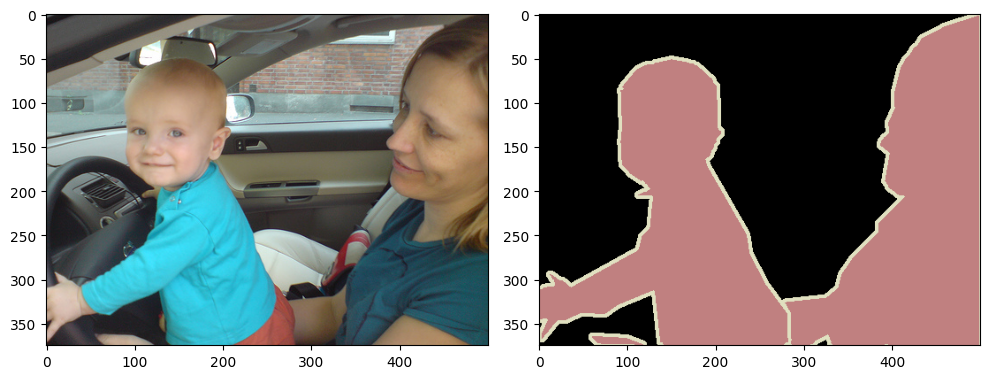

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image)
ax2.imshow(mask)

plt.tight_layout()

In [14]:
selected_mask_names, converted_mask = convert_to_binary_mask(mask)

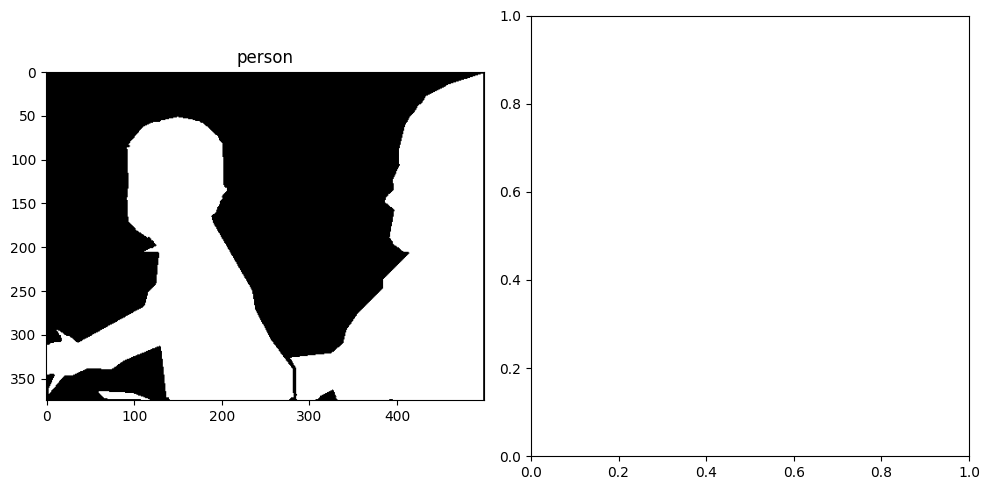

In [15]:
import math 

num_cols = 2
num_rows = math.ceil(len(converted_mask) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows* 5))

for ax, mask_name, image in zip(axes.flatten(), selected_mask_names, converted_mask):
    ax.imshow(image, cmap="gray")
    ax.set_title(mask_name)

plt.tight_layout()

In [17]:
TRAIN_IMAGE_OUTPUT_DIR = IMAGE_OUTPUT_ROOT / "training"
VAL_IMAGE_OUTPUT_DIR = IMAGE_OUTPUT_ROOT / "validation"

print("Copying training images...")
for image_id in tqdm(train_image_ids):
    if not DRYRUN:
        shutil.copy(IMAGE_DIR / f"{image_id}.jpg", TRAIN_IMAGE_OUTPUT_DIR)

print("Copying validation images...")
for image_id in tqdm(val_image_ids):
    if not DRYRUN:
        shutil.copy(IMAGE_DIR / f"{image_id}.jpg", VAL_IMAGE_OUTPUT_DIR)

Copying training images...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:00<00:00, 2263347.24it/s]


Copying validation images...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1449/1449 [00:00<00:00, 2193268.31it/s]
